In [1]:
import numpy as np

In [2]:
import pandas as pd 

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
!git clone https://github.com/natanielruiz/deep-head-pose.git


Cloning into 'deep-head-pose'...
remote: Enumerating objects: 11072, done.
remote: Total 11072 (delta 0), reused 0 (delta 0), pack-reused 11072 (from 1)
Receiving objects: 100% (11072/11072), 216.05 MiB | 6.51 MiB/s, done.
Resolving deltas: 100% (491/491), done.


In [16]:
%cd /Users/smritisrivastava/Desktop/FinalMP/deep-head-pose/code


/Users/smritisrivastava/Desktop/FinalMP/deep-head-pose/code


In [18]:
!pip install torch torchvision opencv-python dlib imutils


In [19]:
import sys
sys.path.append('/Users/smritisrivastava/Desktop/FinalMP/deep-head-pose/code')

from hopenet import Hopenet


In [20]:
import cv2
import dlib
import torch
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from imutils import face_utils
from hopenet import Hopenet
from torchvision import transforms

In [21]:
# Define parameters
BATCH_SIZE = 32
IMG_HEIGHT, IMG_WIDTH = 197, 197
num_classes = 4
epochs_initial = 10
epochs_finetune = 30


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your dataset
dataset_path = '/Users/smritisrivastava/Desktop/FinalMP/Multi class/train'

# Image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create the ImageDataGenerator with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation
)

# Training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 53217 images belonging to 2 classes.
Found 13304 images belonging to 2 classes.


In [25]:
!pip install ultralytics


In [30]:
import os
import shutil
import random
from pathlib import Path

# Source folders
base_path = Path("/Users/smritisrivastava/Desktop/FinalMP/Multi class/train")
drowsy_path = base_path / "drowsy"
notdrowsy_path = base_path / "notdrowsy"

# Destination base
dest_base = Path("/Users/smritisrivastava/Desktop/FinalMP/yolo_dataset")
train_ratio = 0.8
max_images_per_class = 3000  # ✅ Limit to 3000 per class

def collect_images(folder, limit=None):
    image_paths = list(folder.rglob("*.[jJ][pP][gG]")) + list(folder.rglob("*.[jJ][pP][eE][gG]"))
    random.shuffle(image_paths)
    return image_paths[:limit] if limit else image_paths

def split_and_copy(image_paths, label):
    random.shuffle(image_paths)
    split_idx = int(len(image_paths) * train_ratio)
    train_images = image_paths[:split_idx]
    val_images = image_paths[split_idx:]

    for split, split_images in zip(["train", "val"], [train_images, val_images]):
        target_dir = dest_base / split / label
        target_dir.mkdir(parents=True, exist_ok=True)
        for img_path in split_images:
            shutil.copy(img_path, target_dir / img_path.name)

# ✅ Collect images with limit
drowsy_images = collect_images(drowsy_path, limit=max_images_per_class)
notdrowsy_images = collect_images(notdrowsy_path, limit=max_images_per_class)

print(f"Collected {len(drowsy_images)} drowsy images")
print(f"Collected {len(notdrowsy_images)} notdrowsy images")

# Split and copy
split_and_copy(drowsy_images, "drowsy")
split_and_copy(notdrowsy_images, "notdrowsy")

print("Dataset split and copy complete!")


Collected 3000 drowsy images
Collected 3000 notdrowsy images
Dataset split and copy complete!


In [31]:
model = YOLO('yolov8n.pt')  # <- pretrained weights

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.25M/6.25M [00:01<00:00, 6.36MB/s]


In [32]:
from ultralytics import YOLO

# Load a YOLOv8 classification model config
model = YOLO("yolov8s-cls.pt")  # small classification model (pretrained)

# Train the model
model.train(
    data="/Users/smritisrivastava/Desktop/FinalMP/yolo_dataset",  # path to folder with train/ and val/
    epochs=25,
    imgsz=224,  # input image size
    batch=32,
)


New https://pypi.org/project/ultralytics/8.3.131 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.118 🚀 Python-3.11.5 torch-2.3.0 CPU (Apple M1)
engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=/Users/smritisrivastava/Desktop/FinalMP/yolo_dataset, epochs=25, time=None, patience=100, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fals

train: Scanning /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset/train... 4800 images, 0 corrupt: 100%|██████████| 4800/4800 [00:00<00:00, 10196.74it/s]

train: New cache created: /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 197.4±36.2 MB/s, size: 34.7 KB)


val: Scanning /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset/val... 1200 images, 0 corrupt: 100%|██████████| 1200/1200 [00:00<00:00, 11999.07it/s]

val: New cache created: /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/classify/train2
Starting training for 25 epochs...

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.76s/it]

                   all      0.832          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.76s/it]

                   all      0.848          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.77s/it]

                   all      0.848          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.77s/it]

                   all       0.87          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.75s/it]

                   all      0.846          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.75s/it]

                   all      0.873          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:34<00:00,  1.82s/it]

                   all      0.904          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:34<00:00,  1.80s/it]

                   all      0.908          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:35<00:00,  1.84s/it]

                   all      0.896          1

      Epoch    GPU_mem       loss  Instances       Size



      10/25         0G       0.27         32        224: 100%|██████████| 150/150 [05:10<00:00,  2.07s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.78s/it]

                   all       0.92          1

      Epoch    GPU_mem       loss  Instances       Size



      11/25         0G      0.245         32        224: 100%|██████████| 150/150 [05:14<00:00,  2.09s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.78s/it]

                   all      0.906          1

      Epoch    GPU_mem       loss  Instances       Size



      12/25         0G     0.2389         32        224: 100%|██████████| 150/150 [05:10<00:00,  2.07s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.78s/it]

                   all      0.918          1

      Epoch    GPU_mem       loss  Instances       Size



      13/25         0G     0.2342         32        224: 100%|██████████| 150/150 [05:11<00:00,  2.08s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:34<00:00,  1.80s/it]

                   all      0.926          1

      Epoch    GPU_mem       loss  Instances       Size



      14/25         0G     0.2191         32        224: 100%|██████████| 150/150 [05:13<00:00,  2.09s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.76s/it]

                   all      0.916          1

      Epoch    GPU_mem       loss  Instances       Size



      15/25         0G     0.2137         32        224: 100%|██████████| 150/150 [04:58<00:00,  1.99s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.72s/it]

                   all      0.928          1

      Epoch    GPU_mem       loss  Instances       Size



      16/25         0G     0.1967         32        224: 100%|██████████| 150/150 [05:07<00:00,  2.05s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.70s/it]

                   all      0.934          1

      Epoch    GPU_mem       loss  Instances       Size



      17/25         0G     0.1963         32        224: 100%|██████████| 150/150 [05:11<00:00,  2.08s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

                   all      0.937          1

      Epoch    GPU_mem       loss  Instances       Size



      18/25         0G     0.1892         32        224: 100%|██████████| 150/150 [06:11<00:00,  2.48s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:37<00:00,  1.97s/it]

                   all      0.948          1

      Epoch    GPU_mem       loss  Instances       Size



      19/25         0G     0.1766         32        224: 100%|██████████| 150/150 [05:15<00:00,  2.10s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.75s/it]

                   all      0.947          1

      Epoch    GPU_mem       loss  Instances       Size



      20/25         0G     0.1741         32        224: 100%|██████████| 150/150 [05:00<00:00,  2.00s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.75s/it]

                   all      0.951          1

      Epoch    GPU_mem       loss  Instances       Size



      21/25         0G     0.1654         32        224: 100%|██████████| 150/150 [05:07<00:00,  2.05s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.74s/it]

                   all      0.949          1

      Epoch    GPU_mem       loss  Instances       Size



      22/25         0G     0.1586         32        224: 100%|██████████| 150/150 [05:01<00:00,  2.01s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.74s/it]

                   all      0.948          1

      Epoch    GPU_mem       loss  Instances       Size



      23/25         0G     0.1586         32        224: 100%|██████████| 150/150 [05:05<00:00,  2.04s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.78s/it]

                   all      0.947          1

      Epoch    GPU_mem       loss  Instances       Size



      24/25         0G     0.1372         32        224: 100%|██████████| 150/150 [05:04<00:00,  2.03s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:34<00:00,  1.79s/it]

                   all      0.952          1

      Epoch    GPU_mem       loss  Instances       Size



      25/25         0G     0.1416         32        224: 100%|██████████| 150/150 [05:02<00:00,  2.02s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.75s/it]

                   all      0.952          1

25 epochs completed in 2.367 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 10.3MB


Optimizer stripped from runs/classify/train2/weights/best.pt, 10.3MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.5 torch-2.3.0 CPU (Apple M1)
YOLOv8s-cls summary (fused): 30 layers, 5,077,762 parameters, 0 gradients, 12.4 GFLOPs
train: /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset/train... found 4800 images in 2 classes ✅ 
val: /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset/val... found 1200 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.69s/it]


                   all      0.952          1
Speed: 0.0ms preprocess, 23.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x31f007750>
curves: []
curves_results: []
fitness: 0.9762499928474426
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9524999856948853, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9762499928474426}
save_dir: PosixPath('runs/classify/train2')
speed: {'preprocess': 0.00015788083146617282, 'inference': 22.968330348333744, 'loss': 1.71866577147739e-05, 'postprocess': 2.8991665506813053e-05}
task: 'classify'
top1: 0.9524999856948853
top5: 1.0

In [34]:
from ultralytics import YOLO

model = YOLO("runs/classify/train2/weights/best.pt")

results = model.predict(source="/Users/smritisrivastava/Desktop/FinalMP/yolo_dataset/train/drowsy/001_glasses_sleepyCombination_599_drowsy.jpg", imgsz=224)



image 1/1 /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset/train/drowsy/001_glasses_sleepyCombination_599_drowsy.jpg: 224x224 notdrowsy 0.65, drowsy 0.35, 13.5ms
Speed: 3.6ms preprocess, 13.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


In [40]:
results[0].confusion_matrix.plot()


AttributeError: 'Results' object has no attribute 'confusion_matrix'. See valid attributes below.

    A class for storing and manipulating inference results.

    This class provides methods for accessing, manipulating, and visualizing inference results from various
    Ultralytics models, including detection, segmentation, classification, and pose estimation.

    Attributes:
        orig_img (numpy.ndarray): The original image as a numpy array.
        orig_shape (Tuple[int, int]): Original image shape in (height, width) format.
        boxes (Boxes | None): Detected bounding boxes.
        masks (Masks | None): Segmentation masks.
        probs (Probs | None): Classification probabilities.
        keypoints (Keypoints | None): Detected keypoints.
        obb (OBB | None): Oriented bounding boxes.
        speed (dict): Dictionary containing inference speed information.
        names (dict): Dictionary mapping class indices to class names.
        path (str): Path to the input image file.
        save_dir (str | None): Directory to save results.

    Methods:
        update: Updates the Results object with new detection data.
        cpu: Returns a copy of the Results object with all tensors moved to CPU memory.
        numpy: Converts all tensors in the Results object to numpy arrays.
        cuda: Moves all tensors in the Results object to GPU memory.
        to: Moves all tensors to the specified device and dtype.
        new: Creates a new Results object with the same image, path, names, and speed attributes.
        plot: Plots detection results on an input RGB image.
        show: Displays the image with annotated inference results.
        save: Saves annotated inference results image to file.
        verbose: Returns a log string for each task in the results.
        save_txt: Saves detection results to a text file.
        save_crop: Saves cropped detection images to specified directory.
        summary: Converts inference results to a summarized dictionary.
        to_df: Converts detection results to a Pandas Dataframe.
        to_json: Converts detection results to JSON format.
        to_csv: Converts detection results to a CSV format.
        to_xml: Converts detection results to XML format.
        to_html: Converts detection results to HTML format.
        to_sql: Converts detection results to an SQL-compatible format.

    Examples:
        >>> results = model("path/to/image.jpg")
        >>> result = results[0]  # Get the first result
        >>> boxes = result.boxes  # Get the boxes for the first result
        >>> masks = result.masks  # Get the masks for the first result
        >>> for result in results:
        >>>     result.plot()  # Plot detection results
    

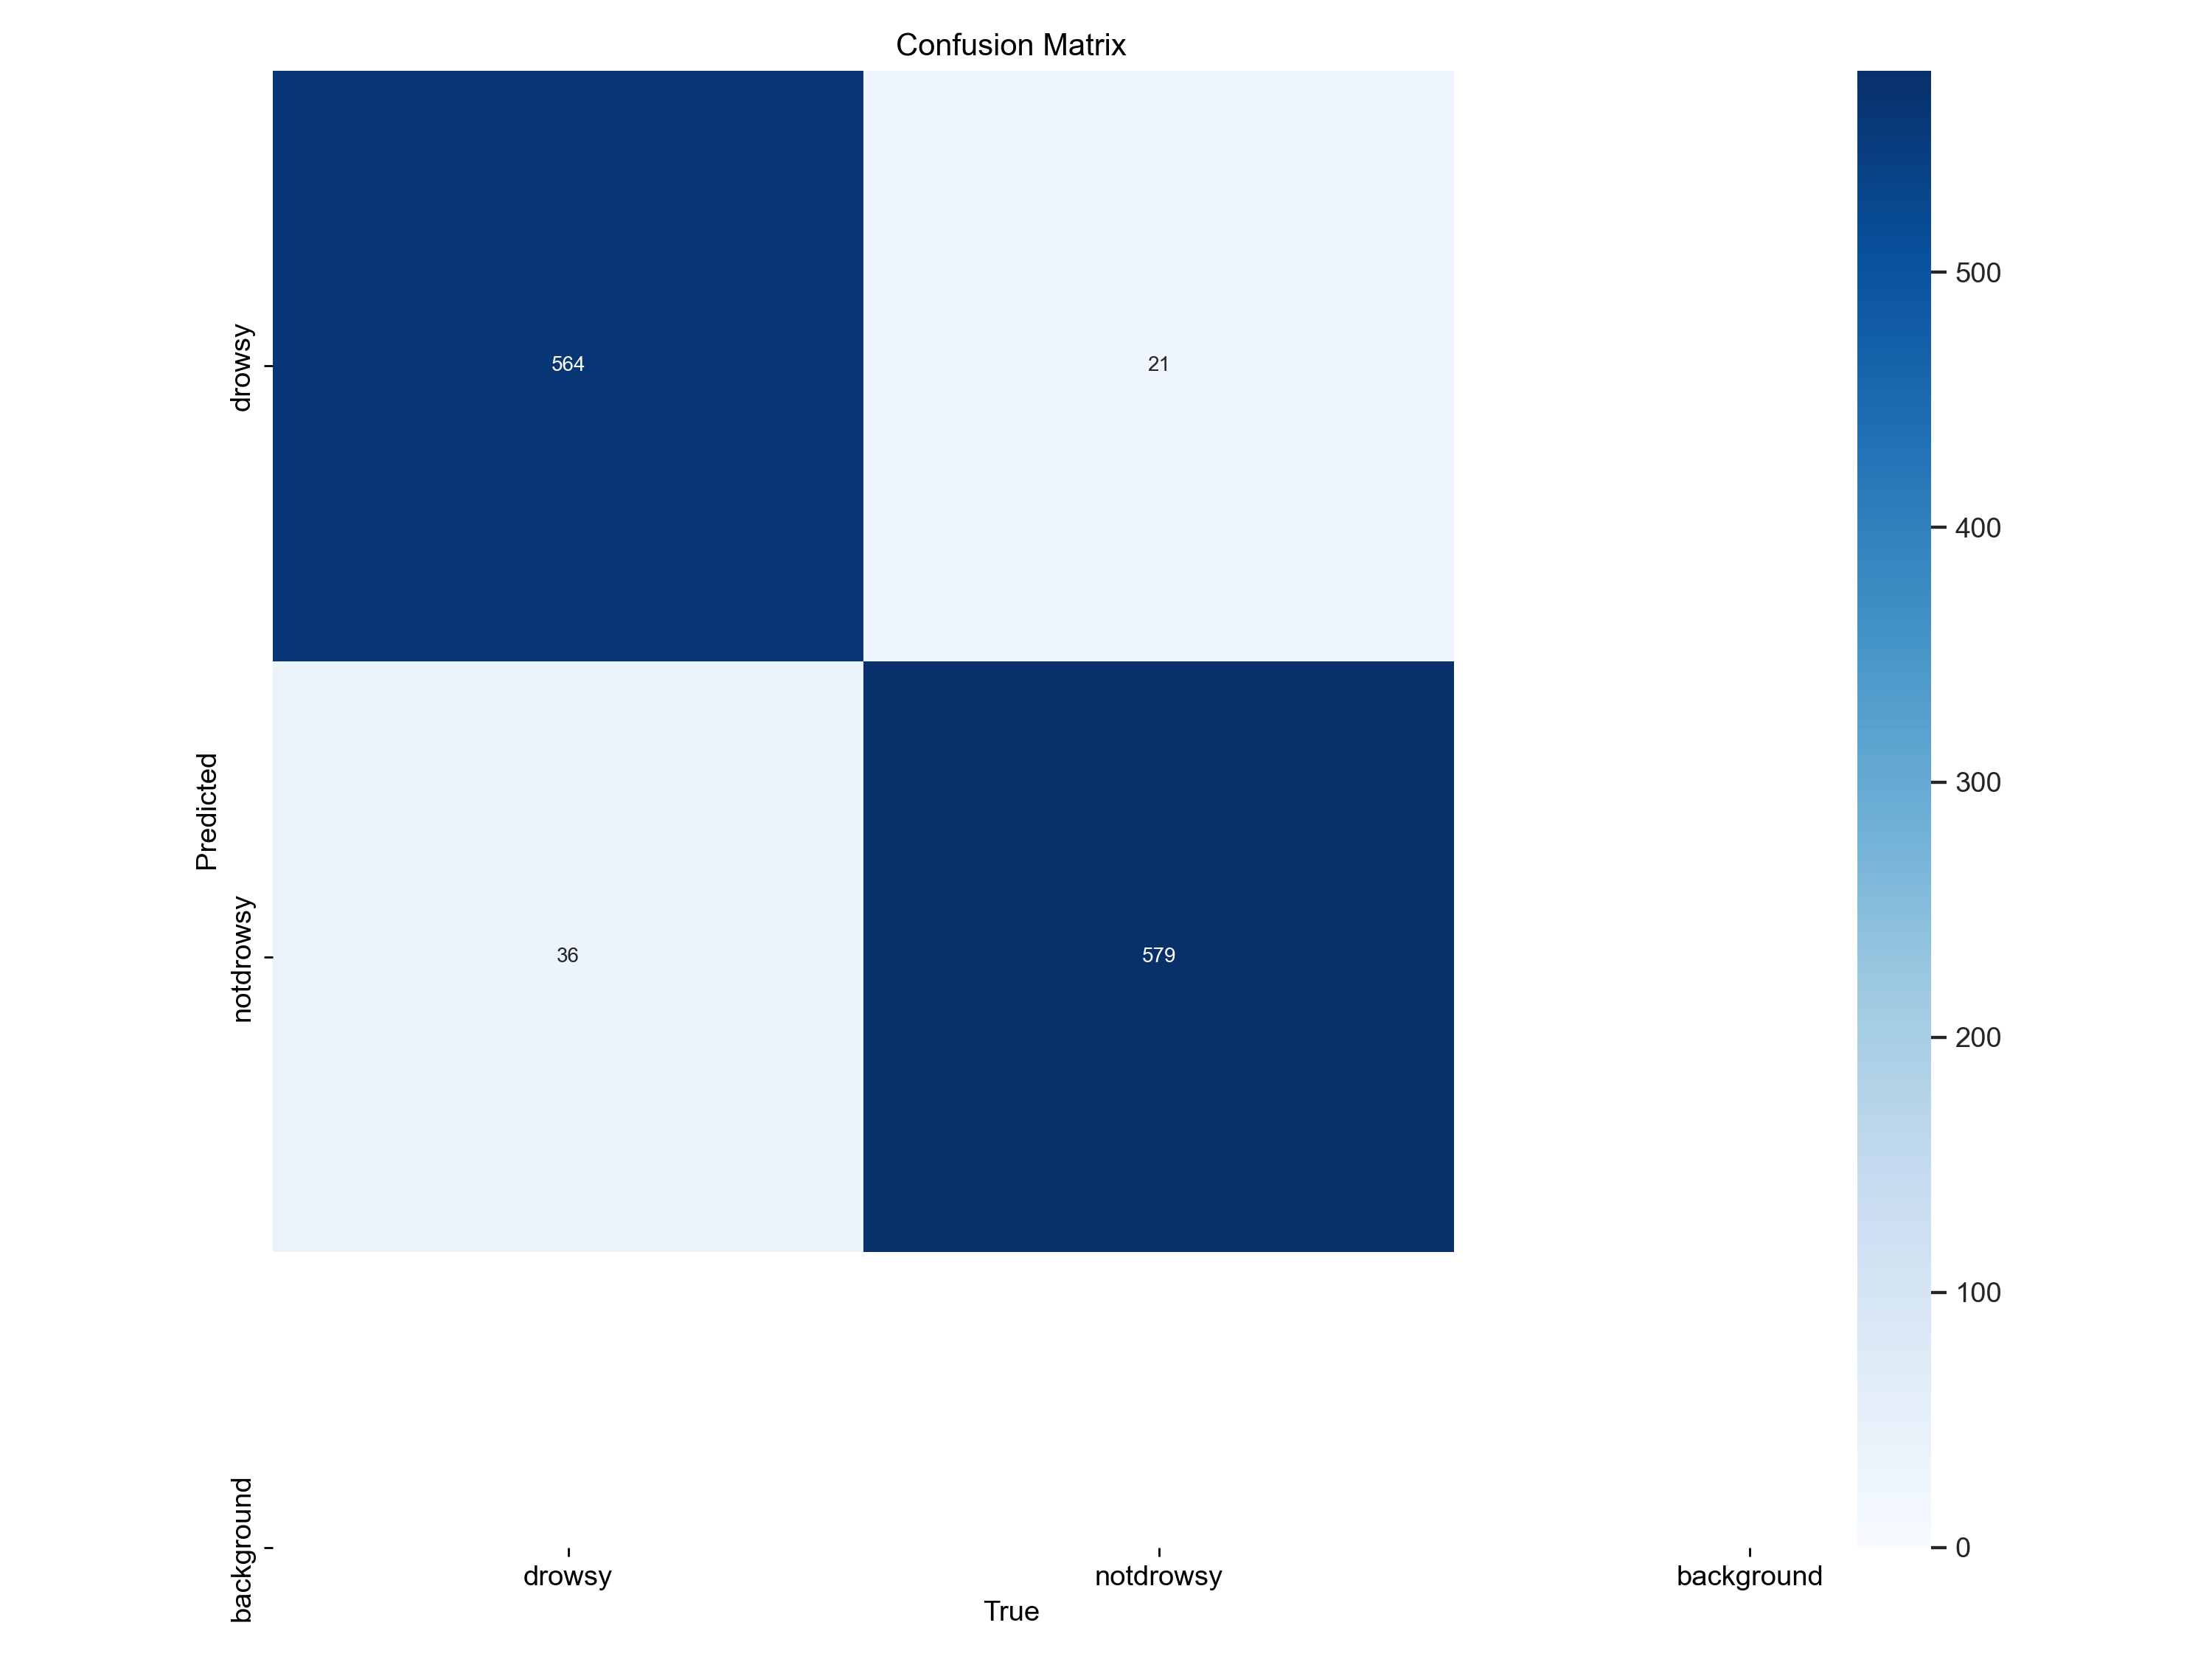

In [36]:
from IPython.display import Image
Image(filename='runs/classify/train2/confusion_matrix.png')


In [37]:
import os
import shutil
import random
from pathlib import Path

# Source folders
base_path = Path("/Users/smritisrivastava/Desktop/FinalMP/Multi class/train")
drowsy_path = base_path / "drowsy"
notdrowsy_path = base_path / "notdrowsy"

# Destination folders
dest_base = Path("/Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_3000")
train_ratio = 0.8
target_count_per_class = 3000

def collect_jpeg_images(folder):
    """Collect all .jpeg or .jpg images recursively."""
    return [p for p in folder.rglob("*.jpeg")] + [p for p in folder.rglob("*.jpg")]

def sample_images(image_paths, count):
    """Randomly sample images."""
    random.shuffle(image_paths)
    return image_paths[:count]

def split_and_copy(sampled_images, label):
    """Split into train/val and copy to new structure."""
    split_idx = int(len(sampled_images) * train_ratio)
    train_images = sampled_images[:split_idx]
    val_images = sampled_images[split_idx:]

    for split, split_images in zip(["train", "val"], [train_images, val_images]):
        target_dir = dest_base / split / label
        target_dir.mkdir(parents=True, exist_ok=True)
        for img_path in split_images:
            shutil.copy(img_path, target_dir / img_path.name)

# Step 1: Collect and sample 3000 images each
drowsy_images = collect_jpeg_images(drowsy_path)
notdrowsy_images = collect_jpeg_images(notdrowsy_path)

print(f"Total drowsy images available: {len(drowsy_images)}")
print(f"Total notdrowsy images available: {len(notdrowsy_images)}")

# Ensure enough images
if len(drowsy_images) < target_count_per_class or len(notdrowsy_images) < target_count_per_class:
    raise ValueError("Not enough images in one or both classes to sample 3000!")

drowsy_sample = sample_images(drowsy_images, target_count_per_class)
notdrowsy_sample = sample_images(notdrowsy_images, target_count_per_class)

# Step 2: Split and copy
split_and_copy(drowsy_sample, "drowsy")
split_and_copy(notdrowsy_sample, "notdrowsy")

print("New balanced dataset created in yolo_dataset_3000!")


Total drowsy images available: 36030
Total notdrowsy images available: 30491
New balanced dataset created in yolo_dataset_3000!


In [38]:
from ultralytics import YOLO

model = YOLO("yolov8s-cls.pt")
model.train(
    data="/Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_3000",
    epochs=25,
    imgsz=224,
    batch=32,
)


New https://pypi.org/project/ultralytics/8.3.131 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.118 🚀 Python-3.11.5 torch-2.3.0 CPU (Apple M1)
engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=/Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_3000, epochs=25, time=None, patience=100, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames

train: Scanning /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_3000/train... 4800 images, 0 corrupt: 100%|██████████| 4800/4800 [00:00<00:00, 10263.77it/s]

train: New cache created: /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_3000/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 207.9±30.8 MB/s, size: 34.8 KB)


val: Scanning /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_3000/val... 1200 images, 0 corrupt: 100%|██████████| 1200/1200 [00:00<00:00, 12105.18it/s]

val: New cache created: /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_3000/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/classify/train3
Starting training for 25 epochs...

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]

                   all      0.822          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]

                   all      0.817          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]

                   all      0.833          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]

                   all      0.874          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.74s/it]

                   all       0.89          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]

                   all      0.842          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.72s/it]

                   all      0.918          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.74s/it]

                   all      0.916          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:34<00:00,  1.80s/it]

                   all      0.898          1

      Epoch    GPU_mem       loss  Instances       Size



      10/25         0G     0.2457         32        224: 100%|██████████| 150/150 [04:50<00:00,  1.94s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.74s/it]

                   all      0.909          1

      Epoch    GPU_mem       loss  Instances       Size



      11/25         0G     0.2269         32        224: 100%|██████████| 150/150 [04:52<00:00,  1.95s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.72s/it]

                   all      0.923          1

      Epoch    GPU_mem       loss  Instances       Size



      12/25         0G     0.2438         32        224: 100%|██████████| 150/150 [04:54<00:00,  1.96s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.72s/it]

                   all      0.918          1

      Epoch    GPU_mem       loss  Instances       Size



      13/25         0G     0.2219         32        224: 100%|██████████| 150/150 [04:55<00:00,  1.97s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]

                   all      0.949          1

      Epoch    GPU_mem       loss  Instances       Size



      14/25         0G     0.2036         32        224: 100%|██████████| 150/150 [04:51<00:00,  1.94s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.72s/it]

                   all      0.942          1

      Epoch    GPU_mem       loss  Instances       Size



      15/25         0G     0.1955         32        224: 100%|██████████| 150/150 [04:53<00:00,  1.95s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.72s/it]

                   all      0.933          1

      Epoch    GPU_mem       loss  Instances       Size



      16/25         0G     0.1999         32        224: 100%|██████████| 150/150 [04:52<00:00,  1.95s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.74s/it]

                   all      0.932          1

      Epoch    GPU_mem       loss  Instances       Size



      17/25         0G     0.1857         32        224: 100%|██████████| 150/150 [04:54<00:00,  1.96s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.74s/it]

                   all      0.933          1

      Epoch    GPU_mem       loss  Instances       Size



      18/25         0G     0.1853         32        224: 100%|██████████| 150/150 [04:56<00:00,  1.98s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.73s/it]

                   all      0.951          1

      Epoch    GPU_mem       loss  Instances       Size



      19/25         0G     0.1766         32        224: 100%|██████████| 150/150 [04:58<00:00,  1.99s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.73s/it]

                   all      0.949          1

      Epoch    GPU_mem       loss  Instances       Size



      20/25         0G     0.1709         32        224: 100%|██████████| 150/150 [04:57<00:00,  1.99s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:32<00:00,  1.73s/it]

                   all      0.956          1

      Epoch    GPU_mem       loss  Instances       Size



      21/25         0G     0.1535         32        224: 100%|██████████| 150/150 [04:58<00:00,  1.99s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.74s/it]

                   all      0.959          1

      Epoch    GPU_mem       loss  Instances       Size



      22/25         0G     0.1561         32        224: 100%|██████████| 150/150 [04:57<00:00,  1.98s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.74s/it]

                   all      0.955          1

      Epoch    GPU_mem       loss  Instances       Size



      23/25         0G     0.1447         32        224: 100%|██████████| 150/150 [04:58<00:00,  1.99s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.75s/it]

                   all      0.959          1

      Epoch    GPU_mem       loss  Instances       Size



      24/25         0G     0.1351         32        224: 100%|██████████| 150/150 [04:58<00:00,  1.99s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.74s/it]

                   all       0.96          1

      Epoch    GPU_mem       loss  Instances       Size



      25/25         0G      0.135         32        224: 100%|██████████| 150/150 [04:59<00:00,  2.00s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:33<00:00,  1.75s/it]

                   all       0.96          1

25 epochs completed in 2.273 hours.
Optimizer stripped from runs/classify/train3/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/train3/weights/best.pt, 10.3MB

Validating runs/classify/train3/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.5 torch-2.3.0 CPU (Apple M1)


YOLOv8s-cls summary (fused): 30 layers, 5,077,762 parameters, 0 gradients, 12.4 GFLOPs
train: /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_3000/train... found 4800 images in 2 classes ✅ 
val: /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_3000/val... found 1200 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:31<00:00,  1.68s/it]


                   all       0.96          1
Speed: 0.0ms preprocess, 22.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train3


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x10e9e1590>
curves: []
curves_results: []
fitness: 0.9799999892711639
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9599999785423279, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9799999892711639}
save_dir: PosixPath('runs/classify/train3')
speed: {'preprocess': 0.00016187415894819424, 'inference': 22.87426093917626, 'loss': 1.2849153184409564e-05, 'postprocess': 2.548667907831259e-05}
task: 'classify'
top1: 0.9599999785423279
top5: 1.0

In [42]:
from ultralytics import YOLO

model = YOLO("runs/classify/train3/weights/best.pt")

results = model.predict(source="/Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_3000/train/notdrowsy/005_glasses_nonsleepyCombination_1094_notdrowsy.jpg", imgsz=224)



image 1/1 /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_3000/train/notdrowsy/005_glasses_nonsleepyCombination_1094_notdrowsy.jpg: 224x224 notdrowsy 1.00, drowsy 0.00, 18.8ms
Speed: 16.8ms preprocess, 18.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


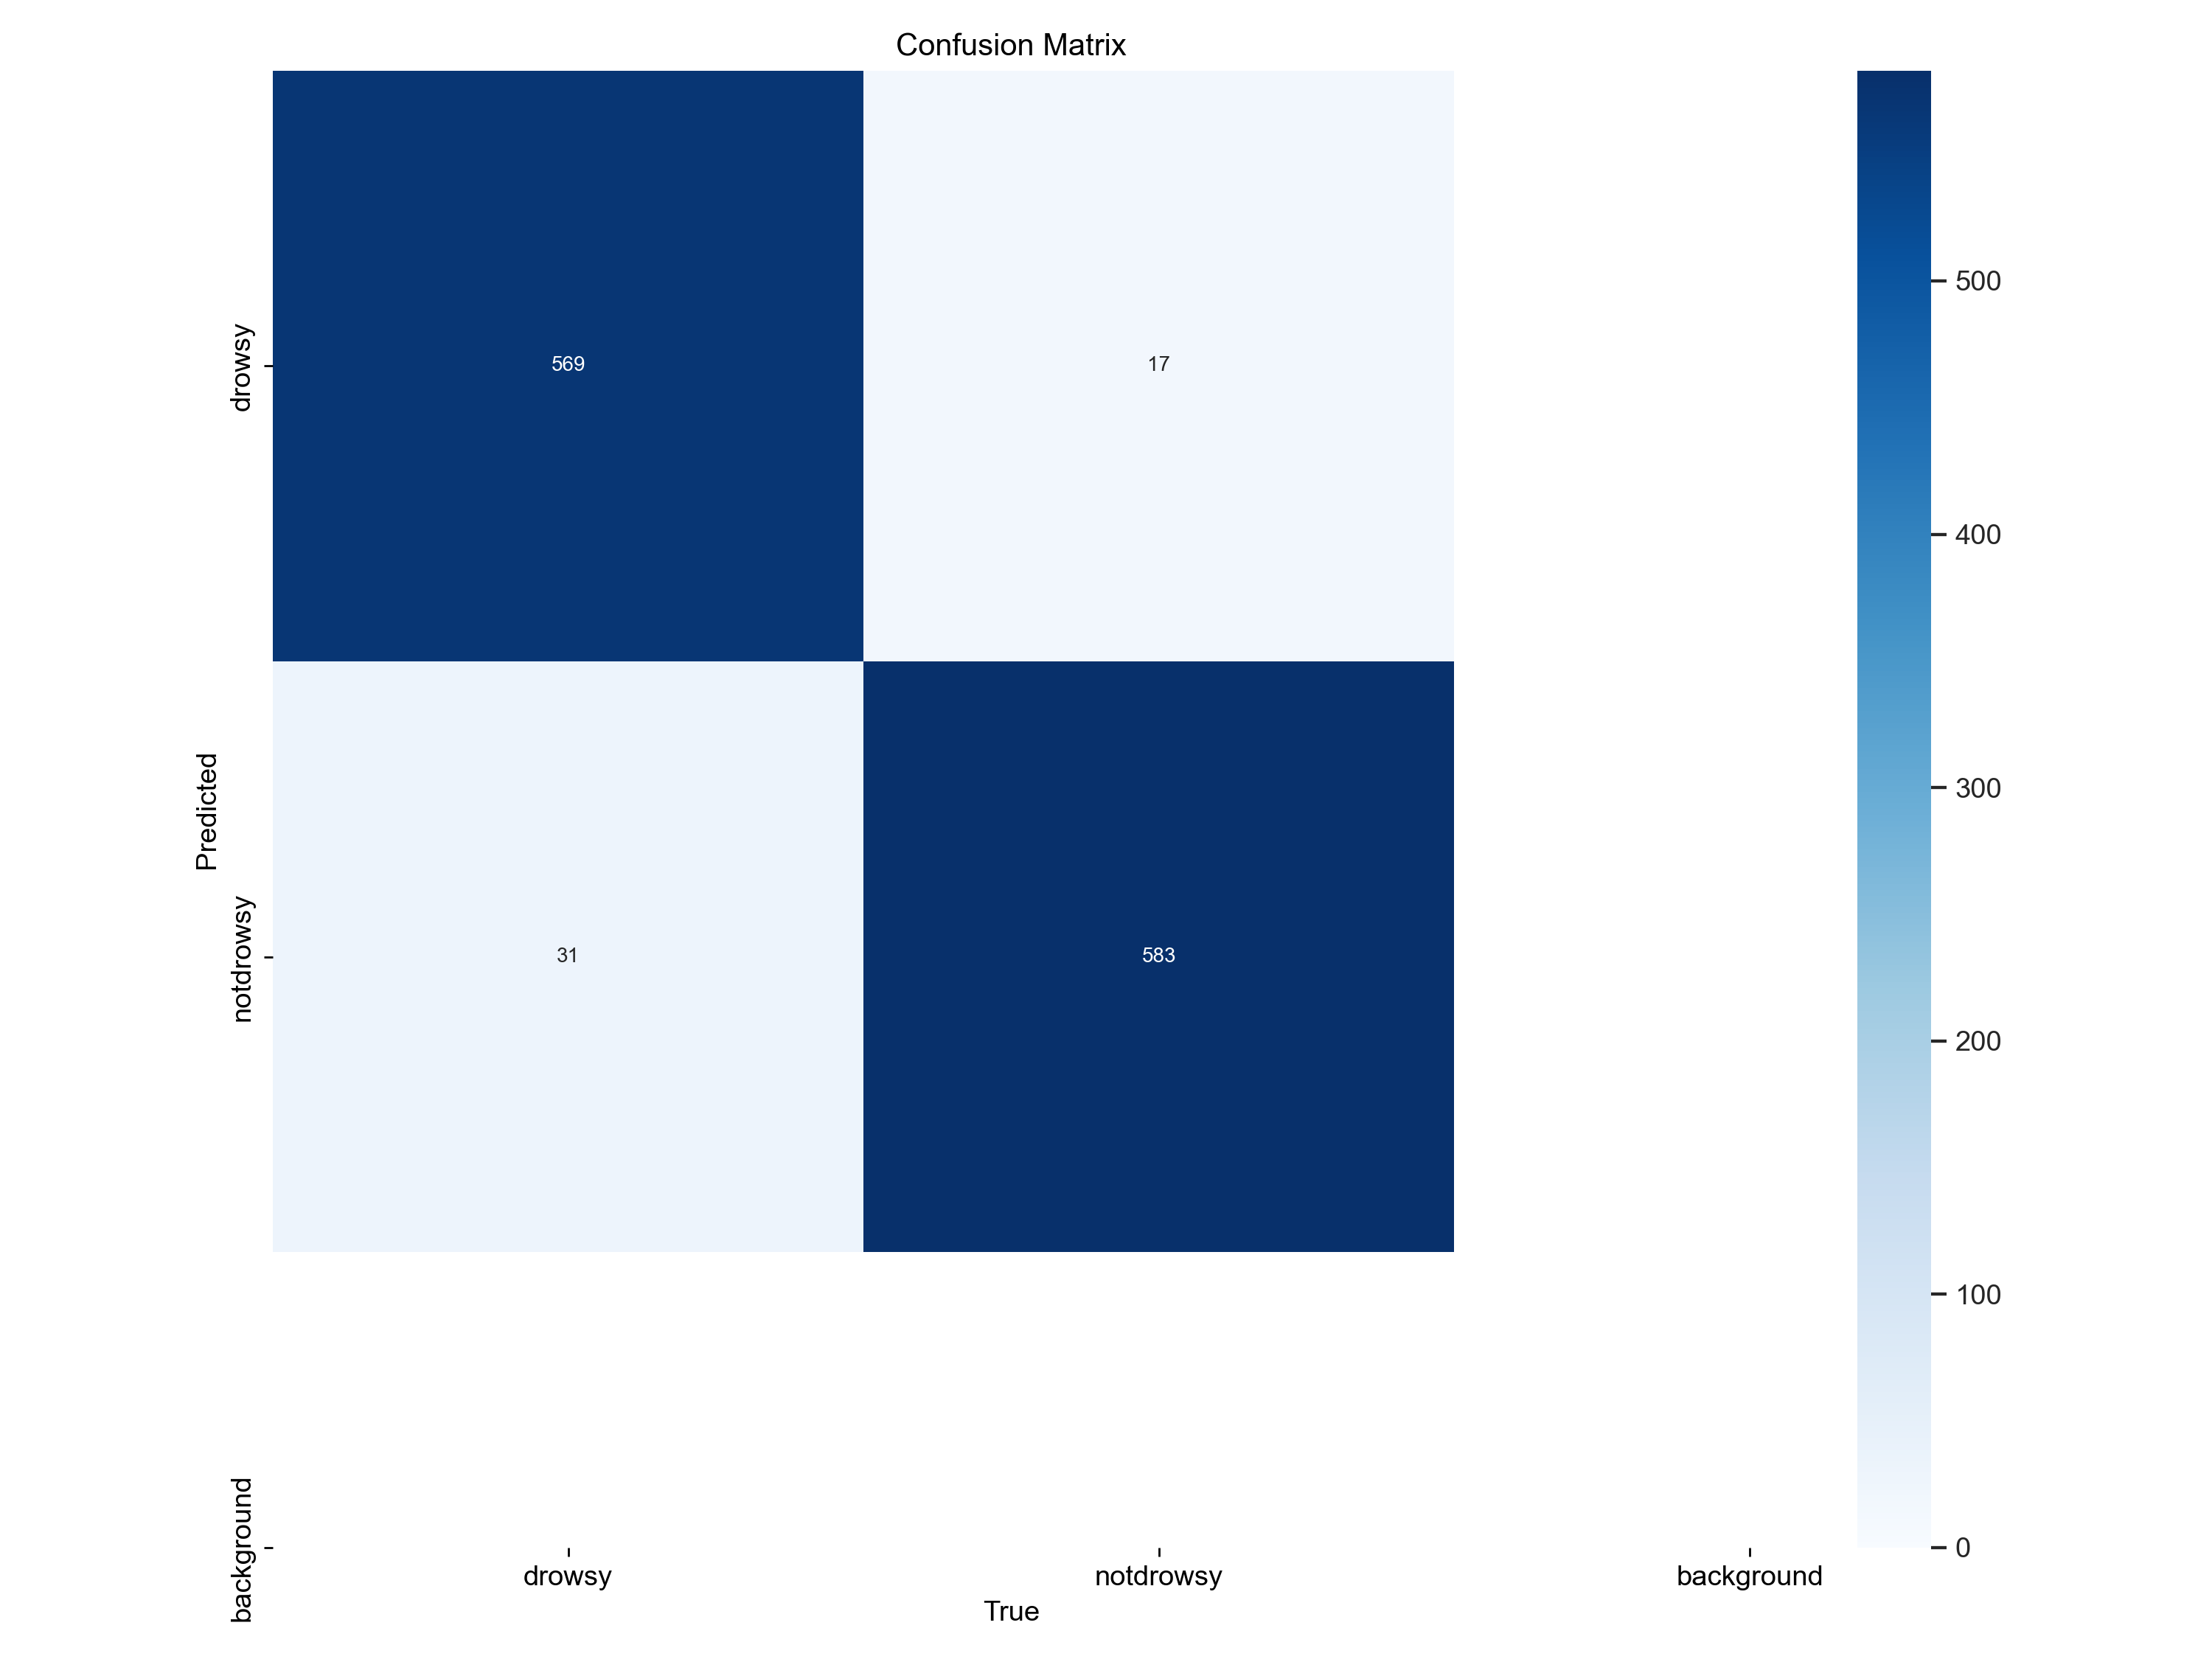

In [41]:
from IPython.display import Image
Image(filename='runs/classify/train3/confusion_matrix.png')


In [44]:
import os
import shutil
import random
from pathlib import Path

# Source base path
base_path = Path("/Users/smritisrivastava/Desktop/FinalMP/Multi class/train")

# Classes and their corresponding subpaths
class_folders = {
    "sleepyCombination": base_path / "drowsy/sleepyCombination",
    "slowBlinkWithNodding": base_path / "drowsy/slowBlinkWithNodding",
    "yawning": base_path / "drowsy/yawning",
    "notdrowsy": base_path / "notdrowsy"
}

# Destination base path
dest_base = Path("/Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_multiclass_3000")

# Parameters
train_ratio = 0.8
target_count_per_class = 750  # 3000 images divided evenly across 4 classes

def collect_jpeg_images(folder):
    return list(folder.rglob("*.jpeg")) + list(folder.rglob("*.jpg"))

def sample_images(image_paths, count):
    random.shuffle(image_paths)
    return image_paths[:count]

def split_and_copy(images, label):
    split_idx = int(len(images) * train_ratio)
    train_images = images[:split_idx]
    val_images = images[split_idx:]

    for split, split_images in zip(["train", "val"], [train_images, val_images]):
        target_dir = dest_base / split / label
        target_dir.mkdir(parents=True, exist_ok=True)
        for img_path in split_images:
            shutil.copy(img_path, target_dir / img_path.name)

# Process each class
for label, path in class_folders.items():
    print(f"Processing class: {label}")
    images = collect_jpeg_images(path)
    print(f"  Found {len(images)} images.")
    
    if len(images) < target_count_per_class:
        raise ValueError(f"Not enough images for class '{label}' (required: {target_count_per_class})")

    sampled = sample_images(images, target_count_per_class)
    split_and_copy(sampled, label)

print("✅ Multi-class dataset of 3000 images created at: yolo_dataset_multiclass_3000")


Processing class: sleepyCombination
  Found 17756 images.
Processing class: slowBlinkWithNodding
  Found 9412 images.
Processing class: yawning
  Found 8862 images.
Processing class: notdrowsy
  Found 30491 images.
✅ Multi-class dataset of 3000 images created at: yolo_dataset_multiclass_3000


In [45]:
from ultralytics import YOLO

model = YOLO("yolov8n-cls.pt")  # or yolov8m-cls.pt for better accuracy

model.train(
    data="/Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_multiclass_3000",
    epochs=25,
    imgsz=224,
    lr0=0.0005
)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.31M/5.31M [00:00<00:00, 6.63MB/s]


New https://pypi.org/project/ultralytics/8.3.131 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.118 🚀 Python-3.11.5 torch-2.3.0 CPU (Apple M1)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_multiclass_3000, epochs=25, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

train: Scanning /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_multiclass_3000/train... 2400 images, 0 corrupt: 100%|██████████| 2400/2400 [00:00<00:00, 8470.33it/s]

train: New cache created: /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_multiclass_3000/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 226.3±46.0 MB/s, size: 34.8 KB)


val: Scanning /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_multiclass_3000/val... 600 images, 0 corrupt: 100%|██████████| 600/600 [00:00<00:00, 11603.14it/s]

val: New cache created: /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_multiclass_3000/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/classify/train4
Starting training for 25 epochs...

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all      0.603          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.08it/s]

                   all      0.662          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.06it/s]

                   all      0.817          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.07it/s]

                   all       0.84          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.05it/s]

                   all       0.87          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.03it/s]

                   all      0.873          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.03it/s]

                   all       0.89          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.03it/s]

                   all      0.918          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.01it/s]

                   all      0.922          1

      Epoch    GPU_mem       loss  Instances       Size



      10/25         0G     0.4342         16        224: 100%|██████████| 150/150 [01:21<00:00,  1.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.03it/s]

                   all       0.91          1

      Epoch    GPU_mem       loss  Instances       Size



      11/25         0G     0.4112         16        224: 100%|██████████| 150/150 [01:20<00:00,  1.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]

                   all       0.93          1

      Epoch    GPU_mem       loss  Instances       Size



      12/25         0G     0.3974         16        224: 100%|██████████| 150/150 [01:20<00:00,  1.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.04it/s]

                   all      0.925          1

      Epoch    GPU_mem       loss  Instances       Size



      13/25         0G     0.3753         16        224: 100%|██████████| 150/150 [01:21<00:00,  1.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.01it/s]

                   all      0.937          1

      Epoch    GPU_mem       loss  Instances       Size



      14/25         0G     0.3533         16        224: 100%|██████████| 150/150 [01:20<00:00,  1.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]

                   all      0.922          1

      Epoch    GPU_mem       loss  Instances       Size



      15/25         0G     0.3435         16        224: 100%|██████████| 150/150 [01:21<00:00,  1.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]

                   all      0.923          1

      Epoch    GPU_mem       loss  Instances       Size



      16/25         0G     0.2999         16        224: 100%|██████████| 150/150 [01:21<00:00,  1.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.01it/s]

                   all      0.933          1

      Epoch    GPU_mem       loss  Instances       Size



      17/25         0G     0.3015         16        224: 100%|██████████| 150/150 [01:21<00:00,  1.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.01it/s]

                   all       0.94          1

      Epoch    GPU_mem       loss  Instances       Size



      18/25         0G     0.2904         16        224: 100%|██████████| 150/150 [01:20<00:00,  1.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.00it/s]

                   all      0.935          1

      Epoch    GPU_mem       loss  Instances       Size



      19/25         0G     0.2879         16        224: 100%|██████████| 150/150 [01:21<00:00,  1.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.01it/s]

                   all      0.937          1

      Epoch    GPU_mem       loss  Instances       Size



      20/25         0G     0.2948         16        224: 100%|██████████| 150/150 [01:21<00:00,  1.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.00it/s]

                   all      0.923          1

      Epoch    GPU_mem       loss  Instances       Size



      21/25         0G     0.2801         16        224: 100%|██████████| 150/150 [01:20<00:00,  1.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.04it/s]

                   all      0.938          1

      Epoch    GPU_mem       loss  Instances       Size



      22/25         0G     0.2612         16        224: 100%|██████████| 150/150 [01:19<00:00,  1.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]

                   all      0.935          1

      Epoch    GPU_mem       loss  Instances       Size



      23/25         0G      0.251         16        224: 100%|██████████| 150/150 [01:21<00:00,  1.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:09<00:00,  1.94it/s]

                   all      0.933          1

      Epoch    GPU_mem       loss  Instances       Size



      24/25         0G     0.2327         16        224: 100%|██████████| 150/150 [01:26<00:00,  1.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:10<00:00,  1.86it/s]

                   all      0.938          1

      Epoch    GPU_mem       loss  Instances       Size



      25/25         0G     0.2429         16        224: 100%|██████████| 150/150 [01:31<00:00,  1.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]

                   all      0.938          1

25 epochs completed in 0.628 hours.
Optimizer stripped from runs/classify/train4/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train4/weights/best.pt, 3.0MB

Validating runs/classify/train4/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.5 torch-2.3.0 CPU (Apple M1)
YOLOv8n-cls summary (fused): 30 layers, 1,440,004 parameters, 0 gradients, 3.3 GFLOPs


train: /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_multiclass_3000/train... found 2400 images in 4 classes ✅ 
val: /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_multiclass_3000/val... found 600 images in 4 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:10<00:00,  1.87it/s]


                   all       0.94          1
Speed: 0.0ms preprocess, 12.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train4


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x10dd1db90>
curves: []
curves_results: []
fitness: 0.9699999988079071
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9399999976158142, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9699999988079071}
save_dir: PosixPath('runs/classify/train4')
speed: {'preprocess': 0.00031965167484789464, 'inference': 12.790848546683264, 'loss': 2.735998956874634e-05, 'postprocess': 5.8886641151426985e-05}
task: 'classify'
top1: 0.9399999976158142
top5: 1.0

In [46]:
from ultralytics import YOLO

model = YOLO("runs/classify/train4/weights/best.pt")
results = model.predict(source="/Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_multiclass_3000/train/notdrowsy/001_glasses_nonsleepyCombination_96_notdrowsy.jpg", imgsz=224)



image 1/1 /Users/smritisrivastava/Desktop/FinalMP/yolo_dataset_multiclass_3000/train/notdrowsy/001_glasses_nonsleepyCombination_96_notdrowsy.jpg: 224x224 sleepyCombination 0.55, notdrowsy 0.45, yawning 0.01, slowBlinkWithNodding 0.00, 14.4ms
Speed: 17.1ms preprocess, 14.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


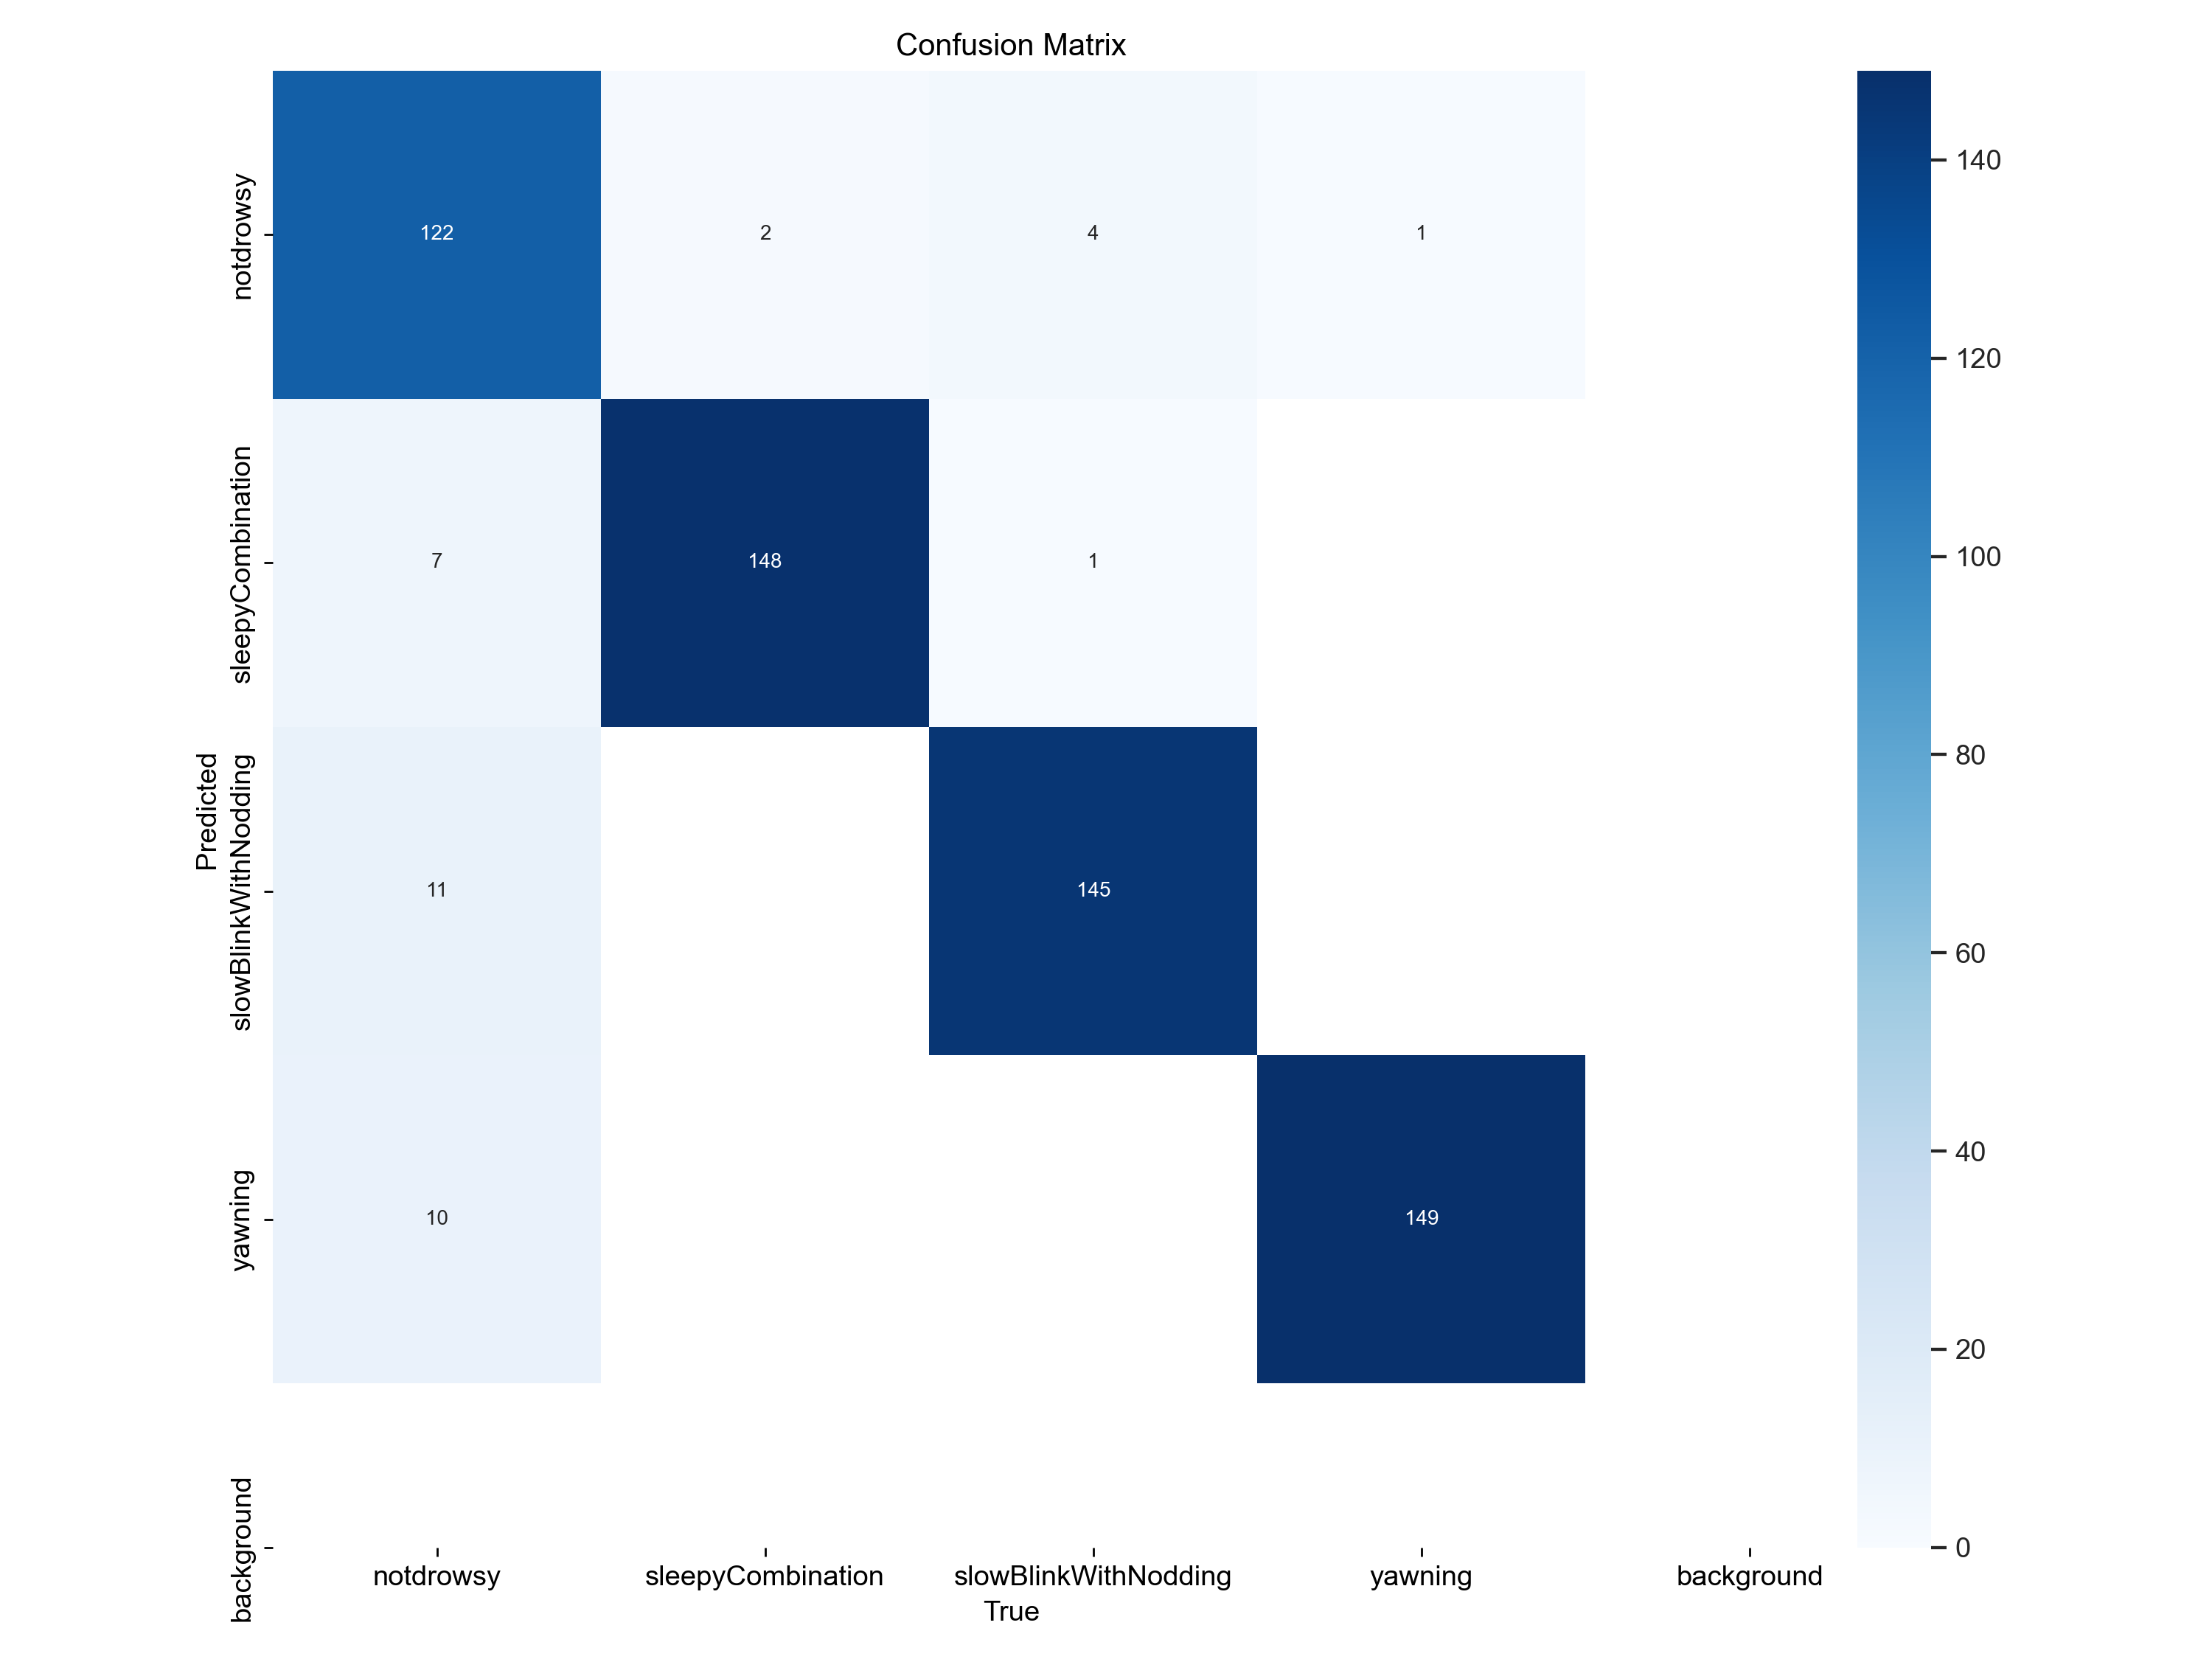

In [49]:
from IPython.display import Image
Image(filename='runs/classify/train4/confusion_matrix.png')
